In [1]:
%matplotlib notebook
import sounddevice as sd # a nice wrapper around pyaudio that simplifies some things
# see: https://python-sounddevice.readthedocs.io/en/0.3.12/usage.html
import numpy as np
import sys
import queue
import math
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

In [2]:
# audio settings
print(sd.query_devices())
print("Default: ",sd.default.device) # sd.default.device is a property that can be set
usedev = sd.default.device
print(sd.default.dtype)
downsample = 10 # plot every Nth sample
window = 200 # visible time window
interval = 200 # minimum time between plot updates in ms
sr = 16000.0
bs = 512
dtype = 'float32'
ch = 1
latency = ('low','high') # see https://python-sounddevice.readthedocs.io/en/0.3.12/api.html#sounddevice.default.dtype
latency = 0.1
q = queue.Queue()

>  0 Built-in Microphone, Core Audio (2 in, 0 out)
<  1 Built-in Output, Core Audio (0 in, 2 out)
   2 Soundflower (2ch), Core Audio (2 in, 2 out)
   3 Soundflower (64ch), Core Audio (64 in, 64 out)
   4 Premiere Pro 5.0, Core Audio (0 in, 0 out)
   5 H2Core, Core Audio (0 in, 2 out)
   6 USBMixer, Core Audio (0 in, 0 out)
   7 Soundblaster PLAY!, Core Audio (0 in, 0 out)
   8 Builtin+SF, Core Audio (64 in, 66 out)
   9 Saffire+SF, Core Audio (64 in, 64 out)
  10 FA101+SF, Core Audio (64 in, 64 out)
Default:  [0, 1]
['float32', 'float32']


In [3]:
# Called by matplotlib for each update of the plot.
def update_plot(frame):
    global ydata
    global line
    chunk = None
    while True:
        try:
            chunk = q.get_nowait()
        except queue.Empty:
            break
    if chunk is not None:
        shift = len(chunk)
        ydata = np.roll(ydata, -shift)
        ydata[-shift:] = chunk[:,0]
        line.set_ydata(ydata)
    return line

<IPython.core.display.Javascript object>


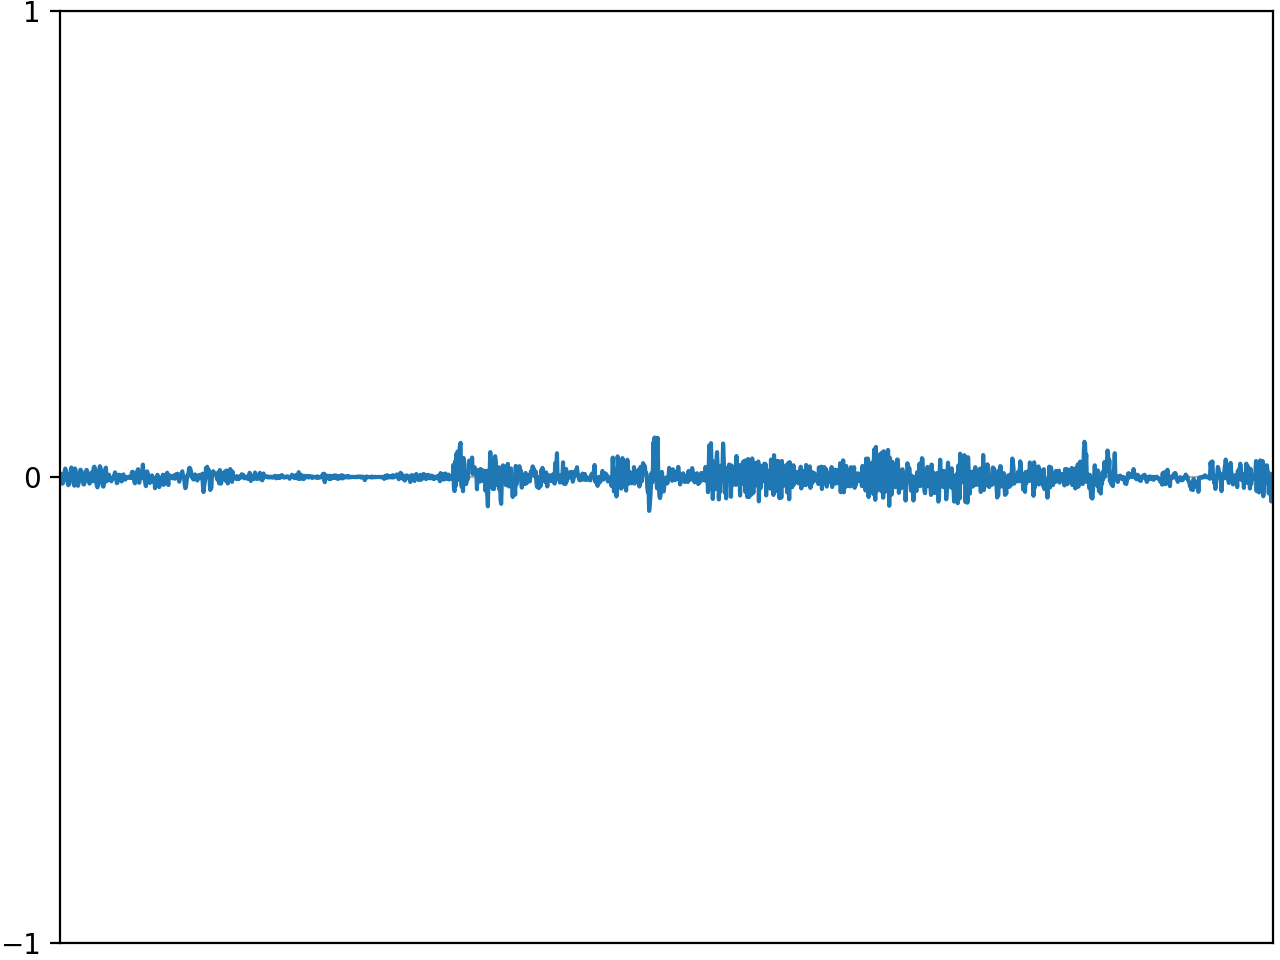

In [4]:
# Make a new figure with a single subplot
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
# Style the subplot for waveform display
axes.set_yticks([-1,0,1])
axes.yaxis.grid(True) # add center 0 line
axes.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=True, labelleft=True)
fig.tight_layout(pad=0)
# Add data & scale the axes accordingly to the shape of the np array containing the data
# See: https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes
resolution = 2000
xdata = np.arange(0.0, 2*math.pi, 2*math.pi / resolution)
ydata = np.sin(xdata)
line, = axes.plot(ydata)
axes.axis((0, len(ydata), -1, 1))

# start animation
FuncAnimation(fig, update_plot, frames=len(xdata), interval=50, blit=True)

In [89]:
# Input routed to output (run callback function and plot function first)

# called (from a separate thread) for each audio block
# indata and outdata are two-dimensional numpy.ndarray with one column per channels (frames, channels) and
# with a datatype specified by dtype when opening the stream. 
# See: https://python-sounddevice.readthedocs.io/en/0.3.12/api.html#sounddevice.Stream
def audio_cb(indata, outdata, frames, time, status):
    global it
    if status:
        print(status, file=sys.stderr)
    downdata = indata[::downsample]
    q.put(downdata) # indexing creates a copy
    outdata[:] = indata

audiostr = sd.Stream(device=(usedev, usedev),samplerate=sr, blocksize=bs,dtype=dtype, latency=latency,channels=ch, callback=audio_cb)
audiostr.start()
# plt.show()

In [5]:
# Input-only stream
def audio_cb_input(indata, frames, time, status):
    global it
    if status:
        print(status, file=sys.stderr)
    downdata = indata[::downsample]
    q.put(downdata) # indexing creates a copyß

audiostr = sd.InputStream(device=usedev, samplerate=sr, latency=latency, blocksize=bs, dtype=dtype, channels=ch, callback=audio_cb_input)
audiostr.start()

In [6]:
# Stop the audio process
audiostr.stop()

In [14]:
# make a queue and load it up with data
q = queue.Queue()

In [37]:
# add steps to the queue
for i in range(len(xdata)):
    q.put(np.sin(xdata + i))

In [22]:
# dequeue and move the sine wave
line.set_ydata(q.get_nowait())

In [38]:
# Called by matplotlib for each update of the plot.
def update_plot(frame):
    global ydata
    global line
    try:
        data = q.get_nowait()
        line.set_ydata(data)
    except queue.Empty:
        pass
    return line

In [45]:
# Animate
FuncAnimation(fig, update_plot, frames=len(xdata), interval=50, blit=True)

3600
3900


In [104]:
plt.clf() # clear all
plt.cla()
plt.close()
